## Week 11: Lecture 2

We have used hypothesis testing to compare a sample and a population. Here we wanted to compare two samples with permutation testing. We will use simulation to provide evidence for accepting or rejecting the guess that the samples comes from the same population. We will find that the implementation of simulations for two sample does not differ from the implementation of simulations for one sample. However, we must sample with replacement in permutation testing.  


Throughout the study of permutation testing, we will study data about health care. 

We will try to compare two samples in a case–control study about links between smoking and infant mortality. Observational studies examine the association of properties within a population. Researchers do not control these properties. Instead researchers oberserve these properties among different groups. The groups are mothers who smoke cigarettes and mothers who do not smoke cigarettes. Here smoking is a factor that may contribute to properties like birth weight associated to infact mortality. 

Experimental studies examine causation among factors within a population. Researchers can control these factors by setting different environments for different groups. We will try to study the treatment of back pain with a drug derived from the Botulinum toxin in a randomized controlled trial. 

In [1]:
# some data science packages

import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 10)
pd.set_option('display.max_columns', 8)

import matplotlib.pyplot as plt
%matplotlib inline

# some helpful functions we wrote for you

from helper_functions import *

### Example (Smoking)

The table births contains the following variables for 1,174 mother-baby pairs: the baby's birth weight in ounces, the number of gestational days, the mother's age in completed years, the mother's height in inches, pregnancy weight in pounds, and whether or not the mother smoked during pregnancy

In [2]:
births = pd.read_csv('baby.csv')
births.head()

,Birth Weight,Gestational Days,Maternal Age,Maternal Height,Maternal Pregnancy Weight,Maternal Smoker
0,120,284,27,62,100,False
1,113,282,33,64,135,False
2,128,279,28,64,115,True
3,108,282,23,67,125,True
4,136,286,25,62,93,False


There are 715 non-smokers among the women in the sample, and 459 smokers. 

In [3]:
smoking = births[births["Maternal Smoker"] == True]
not_smoking = births[births["Maternal Smoker"] == False]

Do we see an association between birth weight and smoking?

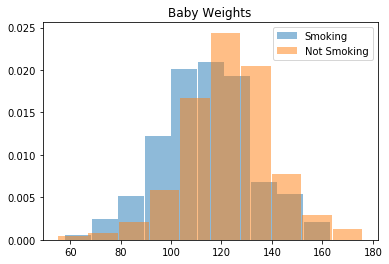

In [4]:
plt.hist(smoking["Birth Weight"], density = True, rwidth = 0.97, alpha = 0.5, label = "Smoking")
plt.hist(not_smoking["Birth Weight"], density = True, rwidth = 0.97, alpha = 0.5, label = "Not Smoking")
plt.title('Baby Weights');
plt.legend();

It appears that smokers have babies with lower weight. Is it chance? Maybe the difference represents an association in the population that could be an indication of a link between smoking and baby weight. 

- Null hypothesis: In the population, the distribution of birth weights of babies is the same for mothers who don't smoke as for mothers who do. The difference in the sample is due to chance.

- Alternative hypothesis: In the population, the babies of the mothers who smoke have a lower birth weight, on average, than the babies of the non-smokers.

We need a test statistic to validate the hypotheses. We will take $$\text{average weight of smoking mother} - \text{average weight of non-smoking mother}$$

In [5]:
smoking_and_birthweight = births[['Maternal Smoker', 'Birth Weight']]

means_table = smoking_and_birthweight.groupby('Maternal Smoker').mean()
means_table

,Birth Weight
Maternal Smoker,
False,123.085315
True,113.819172


In [6]:
observed_difference = means_table.loc[True, "Birth Weight"] - means_table.loc[False, "Birth Weight"]
observed_difference

-9.266142572024918

Let us write a function to compute the difference of averages in a table.

In [7]:
def difference_of_means(table, value_label, group_label):
    table_with_relevant_columns = table[[group_label, value_label]]

    means_table = table_with_relevant_columns.groupby(group_label).mean()
    
    return means_table.loc[True, value_label] - means_table.loc[False, value_label]

In [8]:
difference_of_means(births, 'Birth Weight', 'Maternal Smoker')

-9.266142572024918

Now we want to shuffle the group labels. We make a copy of the table.

In [9]:
smoking_and_birthweight = smoking_and_birthweight.copy()
smoking_and_birthweight.head()

,Maternal Smoker,Birth Weight
0,False,120
1,False,113
2,True,128
3,True,108
4,False,136


We sample without replacement from the `Maternal Smoker` column.

In [10]:
values_to_sample_from = smoking_and_birthweight["Maternal Smoker"]
number_of_samples = len(values_to_sample_from)

shuffled_labels = sample_without_replacement(number_of_samples, values_to_sample_from)

We add the shuffled labels to the table.

In [11]:
smoking_and_birthweight["Shuffled Labels"] = shuffled_labels
smoking_and_birthweight.head()

,Maternal Smoker,Birth Weight,Shuffled Labels
0,False,120,False
1,False,113,False
2,True,128,False
3,True,108,False
4,False,136,True


While some of the labels match between columns, other labels are mismatched. We can compute the test statistic with the shuffled labels.

In [12]:
difference_of_means(smoking_and_birthweight, 'Birth Weight', 'Shuffled Labels')

1.4584548349254192

Notice the difference between the observed statistic -9.26. We want to repeatedly generate test statistic over many trials. We will write a function to simulate one trial. 

In [13]:
def one_simulated_difference(table, value_label, group_label):
    values_to_sample_from = table[group_label]
    number_of_samples = len(table[group_label])

    shuffled_labels = sample_without_replacement(number_of_samples, values_to_sample_from)
    table["Shuffled Labels"] = shuffled_labels
    
    return difference_of_means(table, value_label, "Shuffled Labels")   

Now we can use the function at each trial to compute another test statistic.

In [14]:
trials = 1000
differences = []

for trial in range(trials):
    new_difference = one_simulated_difference(smoking_and_birthweight, 'Birth Weight', 'Maternal Smoker')
    differences.append(new_difference)

Plotting the simulated statistics we notice that the histogram is symmetric about 0.  This makes sense, because under the null hypothesis the two groups should have roughly the same average. Therefore the difference between the group averages should be around 0.

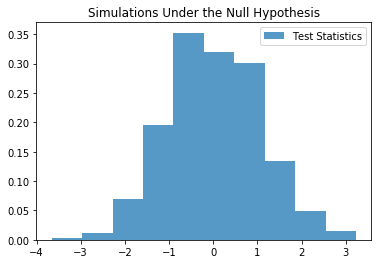

In [15]:
plt.hist(differences, density = True, alpha = 0.75, label = "Test Statistics")
plt.legend()
plt.title('Simulations Under the Null Hypothesis');

However the observed statistic is an outlier

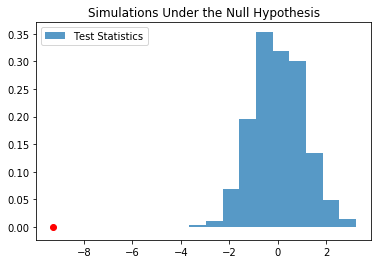

In [16]:
plt.hist(differences, density = True, alpha = 0.75, label = "Test Statistics")
plt.legend()
plt.scatter([observed_difference],[0], color = 'red')
plt.title('Simulations Under the Null Hypothesis');

Note that the p-value is 0

In [17]:
calculate_pvalue(observed_difference, differences)

0.0

The conclusion of the test is that the data favor the alternative over the null. The average birth weight of babies born to mothers who smoke is less than the average birth weight of babies born to non-smokers.

### Exercise (Height)

We expect that smoking might have an effect on the weight of babies. However the height mothers might not have any association with baby weight. We can use the same approach for studying the relationship between smoking and baby weight. However, we need a column consisting of boolean values True or False. Note the maximum and minimum heights.


In [18]:
births = pd.read_csv("baby.csv")

In [19]:
births["Maternal Height"].max()

72

In [20]:
births["Maternal Height"].min()

53

Here 62.5 = (72 + 53) / 2. So we set `height_cutoff`. 

In [21]:
height_cutoff = 62.5

We will divide people into two categories
- taller : height greater than 62.5
- shorter : height less than 62.5

We want to add a column to `births` called `"Tall"`.  The extra columns should contain the value `True` for people who are tall and `False` otherwise. 

**(a)** So we should write a function called `check_nonzero` with 
- input: list containing numbers
- output: list containing True or False

Here we have `True` for values greater than 62.5 and `False` for zero. Note that you can use this function in Lab 7 Question 1.

In [22]:
def check_nonzero(list_of_numbers, cutoff):
    list_for_output = []
    
    for number in list_of_numbers:
        if number > cutoff:
            list_for_output.append(True) 
        else:
            list_for_output.append(False)
    
    return list_for_output

**(b)** Use the function to add the column `Tall` to `births`

In [23]:
new_column = check_nonzero(births["Maternal Height"], height_cutoff)

births["Tall"] = new_column
births

,Birth Weight,Gestational Days,Maternal Age,Maternal Height,Maternal Pregnancy Weight,Maternal Smoker,Tall
0,120,284,27,62,100,False,False
1,113,282,33,64,135,False,True
2,128,279,28,64,115,True,True
3,108,282,23,67,125,True,True
4,136,286,25,62,93,False,False
...,...,...,...,...,...,...,...
1169,113,275,27,60,100,False,False
1170,128,265,24,67,120,False,True
1171,130,291,30,65,150,True,True
1172,125,281,21,65,110,False,True


**(c)** Perform permutation testing to compare `Birth Weight` and `Maternal Height`.

**Step 1:** Fix a null hypothesis and alternative hypothesis

- Null hypothesis: In the population, the distribution of birth weights of babies is the same for tall mothers and short mothers. Any difference in the sample is due to chance.

- Alternative hypothesis: In the population, the babies of tall mothers is different, on average, than the babies of short mothers.

**Step 2:** Determine a test statistic 

We need a test statistic to validate the hypotheses. We will take absolute value of the difference in average weight $$|\text{average weight of tall mothers} - \text{average weight of short mothers}|$$ Note that we measure a distance not a difference because we take absolute value.

**Step 3:** Calculate the observed test statistic for the sample

In [24]:
def absolute_difference_of_means(table, value_label, group_label):
    table_with_relevant_columns = table[[group_label, value_label]]

    means_table = table_with_relevant_columns.groupby(group_label).mean()
    
    return abs(means_table.loc[True, value_label] - means_table.loc[False, value_label])

In [25]:
observed_statistic = difference_of_means(births, 'Birth Weight', 'Tall')
observed_statistic

6.6292467524833825

**Step 4:** Simulate test statistics under the null hypothesis with many trials

In [26]:
def one_simulated_absolute_difference(table, value_label, group_label):
    values_to_sample_from = table[group_label]
    number_of_samples = len(table[group_label])

    shuffled_labels = sample_without_replacement(number_of_samples, values_to_sample_from)
    table["Shuffled Labels"] = shuffled_labels
    
    return absolute_difference_of_means(table, value_label, "Shuffled Labels")   

Now we can use the function at each trial to compute another test statistic.

In [27]:
trials = 1000
differences = []

for trial in range(trials):
    new_difference = one_simulated_difference(births, 'Birth Weight', 'Tall')
    differences.append(new_difference)

**Step 5:** Calculate p-value for the observed test statistic with the empirical distribution.

Lest we data snoop, we should determine an observed significance level. Since the test statistic is positive, we will look in the right tail of the empirical distribution for outliers. We can take the level to be 5% meaning the rejection region will consist of observed test statistic lying above the 95th percentile. 

In [28]:
threshold  = calculate_percentile(differences, 95)
threshold

1.932522188914362

In [29]:
1 - calculate_pvalue(observed_statistic, differences)

0.0

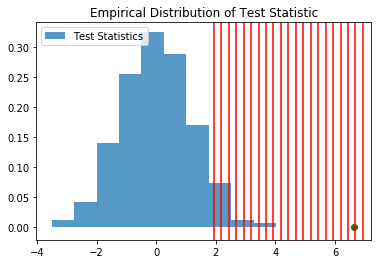

In [30]:
plt.hist(differences, density = True, alpha = 0.75, label = "Test Statistics")
plt.legend()
plt.scatter([observed_statistic],[0], color = 'green')
plt.title('Empirical Distribution of Test Statistic')
for value in np.arange(threshold, 7, 0.25):
    plt.axvline(x = value, color = "r");

**Observations** The permutation test suggests that height of mothers has an association with weight of babies. The labels of tall and short determined a meaning division of the dataset. After partitioning the dataset into the tall mothers and short mothers, we notice a large distance between the average weight of babies. 

**Further Questions**

 - What if we replace distance with difference? Does the test statistic provide evidence that taller mothers have heavier babies?
 - What happens when we change the height cut-off for tall and short from 62.5 inches?


### Example (Back Pain)

The table `bta` contains 31 participants in an experimental study. Since the experiment is a **randomized controlled trial**, the participants are randomly split into a treatment group and a control group. Note `Group` column contains these labels in the form of strings "Control" and "Treatment". Neither researchers nor participants know the division into groups. 

In [31]:
bta = pd.read_csv("bta.csv")
bta

,Group,Result
0,Control,1.0
1,Control,1.0
2,Control,0.0
3,Control,0.0
4,Control,0.0
...,...,...
26,Treatment,0.0
27,Treatment,0.0
28,Treatment,0.0
29,Treatment,0.0


The `Result` column indicates the effect of the treatment. The control group received a placebo in the form a saline solution. The treatment group received a drug derived from the Botulinum toxin. Here 

- 1 indicates relief in back pain
- 0 indicates lack of relief in back pain

Note that we are not using a **cross-over design** in the study meaning that we never repeat the treatment switching participants between groups.

In [33]:
observed_outcomes = pd.read_csv("observed_outcomes.csv")
observed_outcomes

,Group,Outcome if assigned treatment,Outcome if assigned control
0,Control,Unknown,1
1,Control,Unknown,1
2,Control,Unknown,0
3,Control,Unknown,0
4,Control,Unknown,0
...,...,...,...
26,Treatment,0,Unknown
27,Treatment,0,Unknown
28,Treatment,0,Unknown
29,Treatment,0,Unknown


Since we cannot repeat the experiment, we will perform permutation testing to provide evidence of a **causal link** between drug and relief.

**Step 1:** Fix a null hypothesis and alternative hypothesis

 - Null Hypothesis: The distribution of all 31 potential "treatment" outcomes is the same as that of all 31 potential "control" outcomes. Botulinum toxin does nothing different from placebo; the difference in the two samples is just due to chance.

 - Alternative Hypothesis: The distribution of 31 potential "treatment" outcomes is different from that of the 31 control outcomes. The treatment does something different from the control

**Step 2:** Determine a test statistic 

Since we have a qualitative variable not a quantitative variable, we should use total variation distance to compare the proportion of relief and proportion of no relief across the groups

In [151]:
def total_variation_distance(table, value_label, group_label):
    ...

**Step 3:** Calculate the observed test statistic for the sample

In [36]:
observed_statistic = total_variation_distance(bta, "Result", "Group")
observed_statistic

0.475

**Step 4:** Simulate test statistics under the null hypothesis with many trials

In [35]:
def one_simulated_total_variation_distance(table, value_label, group_label):
    values_to_sample_from = table[group_label]
    number_of_samples = len(table[group_label])

    shuffled_labels = sample_without_replacement(number_of_samples, values_to_sample_from)
    table["Shuffled Labels"] = shuffled_labels
    
    return total_variation_distance(table, value_label, "Shuffled Labels")   

Now we can use the function at each trial to compute another test statistic.

In [167]:
trials = 10000
differences = []

for trial in range(trials):
    new_difference = one_simulated_total_variation_distance(bta, 'Result', 'Group')
    differences.append(new_difference)

**Step 5:** Calculate p-value for the observed test statistic with the empirical distribution.

Lest we data snoop, we should determine an observed significance level. Since the test statistic is positive, we will look in the right tail of the empirical distribution for outliers. We can take the level to be 5% meaning the rejection region will consist of observed test statistic lying above the 95th percentile. 

In [168]:
threshold  = calculate_percentile(differences, 95)
threshold

0.3458333333333333

In [169]:
1 - calculate_pvalue(observed_statistic, differences)

0.0021999999999999797

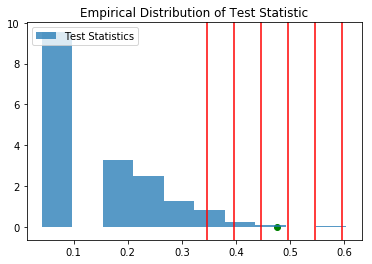

In [170]:
plt.hist(differences, density = True, alpha = 0.75, label = "Test Statistics")
plt.legend()
plt.scatter([observed_statistic],[0], color = 'green')
plt.title('Empirical Distribution of Test Statistic')
for value in np.arange(threshold, 0.6, 0.05):
    plt.axvline(x = value, color = "r");

**Observations** Because the trials were randomized, the test is evidence that the treatment causes the difference. The random assignment of patients to the two groups ensures that there is no confounding variable that could affect the conclusion of causality.

**Further Questions**

 - What would have happened without randomization in dividing the participants?

